In [1]:
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
def f(x):
    return ss.norm(30, 10).pdf(x) + ss.norm(80,20).pdf(x)


def g(x):
    return ss.norm(50, 30).pdf(x)


x = np.arange(-50, 151)
k = max(f(x) / g(x))
def R3(iter=1000):
    samples = []

    for i in range(iter):
        y = np.random.normal(50, 30)
        u = np.random.uniform(0, k*g(y))

        if u <= f(y):
            samples.append(y)

    return np.array(samples)


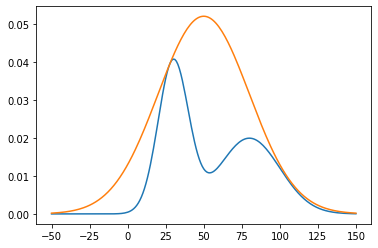

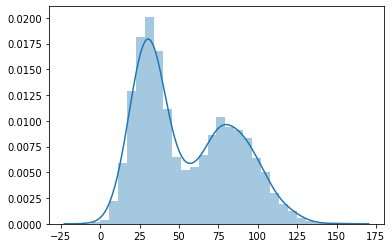

In [21]:
plt.plot(x, f(x))
plt.plot(x, k*g(x))
plt.show()

s = R3(iter=10000)
sns.distplot(s)

In [2]:
import math
import numpy as np
import torch
from torch.distributions import Normal, Uniform

def s():
    z1 = Normal(0,1).sample()
    ctr = 1
    z2 = R1(z1)
    # the following is used to avoid tail recursion  - simple solution and stops stack overflow
    # You can not use this trick straight forwardly if you wish to access multiple core / threads.
    while z2 == math.inf:
        z2 = R1(z1)
        ctr += 1
    z3 = Uniform(0,2).sample()
    z4 = R2(z2,z3)
    z5 = Normal(50,30).sample()
    z6 = R3(z5)
    return torch.tensor([z1,z2,z3,z4,z5,z6])

def R2(z2,z3):
    ''' Need to ensure that we don't return a
    value generated from a deterministic process, i.e if return temp=0, that
    has not been generated from the while loop - although with R1 defined as it is
    this will never be the case'''
    temp = 0
    while temp < z2:
        temp = Normal(z3,1).sample()
    return temp

# recursion-free
def R1(z1, i=0):
    i = 0
    bs = 1
    while True:
        temp = Normal(z1, 1).sample()
        if temp > 0:
            return temp
        if i >= 10000:
            return math.inf
        i += bs


def f(x, mu1, sigma1, mu2, sigma2):
    const1 =  1 / (2 * np.pi * sigma1 ** 2 *torch.ones(x.shape)) ** 0.5
    const2 =  1 / (2 * np.pi * sigma2 ** 2 *torch.ones(x.shape)) ** 0.5
    body1 =  torch.exp(-(x - mu1*torch.ones(x.shape)) ** 2 / (2 * sigma1 ** 2 *torch.ones(x.shape)))
    body2 =  torch.exp(-(x - mu2*torch.ones(x.shape)) ** 2 / (2 * sigma2 ** 2 *torch.ones(x.shape)))
    return  const1*body1 + const2*body2

def g(x,mu1, sigma1):
    const = 1 / (2 * np.pi * sigma1 ** 2 *torch.ones(x.shape)) ** 0.5
    body = torch.exp(-(x - mu1) *torch.ones(x.shape) ** 2 / (2 * sigma1 ** 2 *torch.ones(x.shape)))
    return const * body

#recursion free. Can use mine or chris' technique
# In writing the loops in this way, we force acceptance for the sake
# of computation. 
def R3(z,M):
    ' This fucntion will always return z back, eventually'
    tempg = g(z, 50,30)
    tempf  = f(z,30,10,80,20)
    u = Uniform(0,M*tempg).sample()
    i =0
    bs = 1
    while True:
        if u <= tempf:
            return z, tempg, tempf
        if i>=10000:
            return math.inf, tempg, tempf
        i += bs

In [14]:
import seaborn as sns

nsamples = 100

# determine a good k value for the proposal d
x = torch.linspace(-50.0, 151.0, nsamples)
M = torch.max(f(x,30,10,80,20) /g(x,50,30))

gx  = torch.zeros(nsamples)
fx = torch.zeros(nsamples)
samples = torch.zeros(nsamples)
for i in range(nsamples):
    z5 = Normal(50,30).sample()
    z6, gz, fz = R3(z5,M)
    while z6 == math.inf:
        z5 = Normal(50,30).sample()
        z6, gz, fz = R3(z5, M)
    samples[i,0] = z6
    samples[i,1] = z5
    if i % 1000 ==0:
        print('Sample {}'.format(i))
    gx[i]= gz
    fx[i] =fz

    

tensor(3.0337)


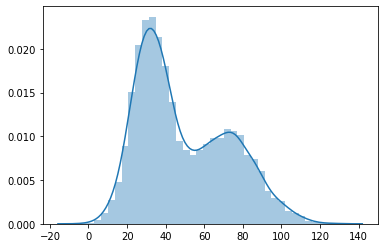

In [7]:
sns.distplot(samples)


tensor(0.0408)


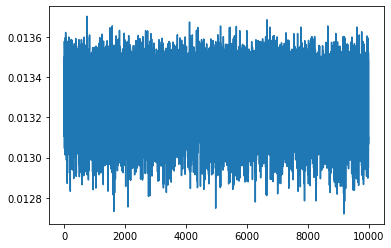

In [13]:
plt.plot(gx)
# plt.plot(fx)
print(torch.max(fx))
plt.show()